# Predicting Student Dropout

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out. In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.

We will work with the data in three distinct stages:

1.  Applicant and course information
2.  Student and engagement data
3.  Academic performance data

These stages reflect the company's real-world data journey and how student information has progressed and become available. This approach will also assist you in determining at which stage of the student journey interventions would be most effective.

## Business context
The company specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. Study Group runs several International Study Centres across the UK and Dublin in partnership with universities with the aim of preparing a pipeline of talented international students from diverse backgrounds for degree study.

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scikeras.wrappers import KerasClassifier
import sklearn

import xgboost as xgb

import shap

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.callbacks import History

In [142]:
# Set random seed for reproducability
seed = 42
np.random.seed(seed)

---

## Stage 1 Data

The data set contains 25,059 rows, each representing a learner with details about the learner (e.g. nationality or home country). It encompasses data related to the entire course and provides an overview of the learner's performance and engagement throughout the course. The Stage 1 data set has 16 features:

* `CentreName`: Study Group centre name/identifier
* `LearnerCode`: Student identifier
* `BookingType`: The type of booking made for the course
* `LeadSource`: How the learner found out about the course
* `DiscountType`: The type of discount applied to the learner’s course fees, if any
* `DateofBirth`: The student's date of birth
* `Gender`: The student’s gender
* `Nationality`: The student's nationality
* `HomeState`: The state or province where the learner's permanent residence is located
* `HomeCity`: The city where the learner's permanent residence is located
* `CourseLevel`: The academic level of Study Group course, e.g. foundation, International Year 1 or Pre-Masters
* `CourseName`: The full name of the course studied, e.g. Pre-Masters Business
* `IsFirstIntake`: A boolean indicating if this is the learner's first intake for the course
* `CompletedCourse`: Yes/No whether the student completed the course
* `ProgressionDegree`: The student’s intended degree of study at the partner university (if eligible to progress)
* `ProgressionUniversity`: The student’s intended partner university (if eligible to progress)

### Initial Data Exploration & Feature Engineering

First we will visualise the data set and do some initial exploring including calculating the number of null/missing values, and calculating the number of unique values for the categorical columns.

In [143]:
# Import and visualise data
df1 = pd.read_csv("../data/Stage1_data.csv")

print(df1.shape)
df1.head()

(25059, 16)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen


In [144]:
# Display the data types of the columns and check for missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUniversi

In [145]:
# Identify the columns with a large number of unique values
df1.nunique()

CentreName                  19
LearnerCode              24877
BookingType                  2
LeadSource                   7
DiscountType                11
DateofBirth               4705
Gender                       2
Nationality                151
HomeState                 2448
HomeCity                  5881
CourseLevel                  4
CourseName                 172
IsFirstIntake                2
CompletedCourse              2
ProgressionDegree         2616
ProgressionUniversity       40
dtype: int64

In [146]:
# Check for any null or missing values
pd.isnull(df1).sum()

CentreName                   0
LearnerCode                  0
BookingType                  0
LeadSource                   0
DiscountType             17464
DateofBirth                  0
Gender                       0
Nationality                  0
HomeState                16134
HomeCity                  3448
CourseLevel                  0
CourseName                   0
IsFirstIntake                0
CompletedCourse              0
ProgressionDegree          875
ProgressionUniversity        0
dtype: int64

Categorical columns with a large number of unique values will lead to an explosion of features when categorical encoding has taken place. This is extremely inefficient with respect to memory and can lead to overfitting. As such, categorical features with high cardinality will be dropped from the data set.

In [147]:
def drop_high_cardinality_columns(df, max_unique_threshold=200):
    """
    Drops categorical columns with more than `max_unique_threshold` unique values.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    max_unique_threshold (int): Maximum allowed unique values for categorical columns

    Returns:
    pd.DataFrame: DataFrame with high-cardinality columns dropped
    """
    df = df.copy()
    dropped_columns = []

    for column in df.select_dtypes(include=['object', 'category']).columns:
        unique_count = df[column].nunique()
        if unique_count > max_unique_threshold:
            df.drop(columns=[column], inplace=True)
            dropped_columns.append((column, unique_count))

    if dropped_columns:
        print("Dropped high-cardinality categorical columns:")
        for col, count in dropped_columns:
            print(f"  - '{col}' with {count} unique values")
    else:
        print("No categorical columns exceeded the unique value threshold.")

    return df

Missing values also present a problem in supervised learning as they disrupt the model's ability to learn from the data. We will handle the missing data by dropping features with a large number of missing values, imputing missing data with the mean (numerical) or mode (categorical) for features that contain a few missing values, and dropping rows where there are only a few missing values which will not pervasively impact the sample size.

In [148]:
def impute_or_drop_all(df, threshold=0.02, upper_threshold=0.5):
    """
    Cleans missing values in a DataFrame:
    - Drops column if missing values > upper_threshold
    - Imputes if threshold < missing ≤ upper_threshold:
        - Mean for numeric columns
        - Mode for non-numeric columns
    - Drops rows with missing values if missing ≤ threshold

    Parameters:
    df (pd.DataFrame): Input DataFrame
    threshold (float): Lower threshold for row drops (e.g., 0.02 = 2%)
    upper_threshold (float): Upper threshold for dropping entire columns (e.g., 0.5 = 50%)

    Returns:
    pd.DataFrame: Cleaned DataFrame
    """
    df = df.copy()
    total_rows = len(df)

    for column in df.columns.tolist():  # .tolist() to avoid issues if column is dropped during iteration
        missing_count = df[column].isna().sum()
        if missing_count == 0:
            continue

        missing_ratio = missing_count / total_rows

        if missing_ratio > upper_threshold:
            df.drop(columns=[column], inplace=True)
            print(f"Dropped column '{column}' with {missing_ratio*100:.1f}% missing values")
        elif missing_ratio > threshold:
            if pd.api.types.is_numeric_dtype(df[column]):
                mean_value = df[column].mean()
                df.fillna({column: mean_value}, inplace=True)
                print(f"Imputed numeric column '{column}' with mean: {mean_value}")
            else:
                mode_series = df[column].mode()
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    df[column].fillna(mode_value, inplace=True)
                    print(f"Imputed non-numeric column '{column}' with mode: '{mode_value}'")
                else:
                    print(f"Skipped column '{column}': no mode found for imputation")
        else:
            df = df[df[column].notna()]
            print(f"Dropped {missing_count} rows due to missing values in '{column}'")

            # Update row count after row drops
            total_rows = len(df)

    return df

As well as the pre-processing above, we will also conduct some feature engineering by extracting potentially useful information and dropping unhelpful information.

In [149]:
def pre_processing(df):
    """
    Full pre-processing of a DataFrame:
    - Converts target variable to binary feature
    - Transforms DateofBirth into Age feature
    - Drops unhelpful columns
    - Drops columns with large number of unique values
    - Handles missing or null values

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    pd.DataFrame: Pre-processed DataFrame
    """
    df = df.copy()
    
    # Convert the target variable to a binary column called "Dropout"
    df["Dropout"] = df["CompletedCourse"].apply(lambda x: 1 if x == "No" else 0)

    # Convert the DateofBirth feature into Age
    today = datetime.today()
    df["Age"] = df["DateofBirth"].apply(lambda x: today.year - datetime.strptime(x, "%d/%m/%Y").year if pd.notnull(x) else None)

    # Drop columns that aren't useful from the dataframe (created new target column)
    df = df.drop(["LearnerCode", "CompletedCourse"], axis=1)

    # Drop columns where they have over a certain threshold of unique values
    df = drop_high_cardinality_columns(df, max_unique_threshold=200)

    # Handles missing / Null values
    df = impute_or_drop_all(df, threshold=0.02, upper_threshold=0.5)

    return df

In [150]:
# Perform pre-processing
df1 = pre_processing(df1)

# Visualise the new dataframe
df1.head()

Dropped high-cardinality categorical columns:
  - 'DateofBirth' with 4705 unique values
  - 'HomeState' with 2448 unique values
  - 'HomeCity' with 5881 unique values
  - 'ProgressionDegree' with 2616 unique values
Dropped column 'DiscountType' with 69.7% missing values


,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,ProgressionUniversity,Dropout,Age
0,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,University of Aberdeen,0,27
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,False,University of Aberdeen,0,27
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,False,University of Aberdeen,0,25
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,University of Aberdeen,0,26
4,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,University of Aberdeen,0,29


In [151]:
# Check for any remaining null or missing values
pd.isnull(df1).sum()

CentreName               0
BookingType              0
LeadSource               0
Gender                   0
Nationality              0
CourseLevel              0
CourseName               0
IsFirstIntake            0
ProgressionUniversity    0
Dropout                  0
Age                      0
dtype: int64

Categorical columns can't be handled by a Neural Network in their current form and must be encoded into numerical features. Ordered columns will be handled with ordinal encoding, and other categorical columns will undergo one-hot encoding to create a binary column for each feature.

In [152]:
# Course level is identified as an ordinal column, identify unique values
df1["CourseLevel"].unique()

array(['Pre-Masters', 'Foundation', 'International Year Two',
       'International Year One'], dtype=object)

In [153]:
def categorical_encoding(df):
    """
    Encodes categorical features in a DataFrame:
    - Ordinal encoding for variables with ordered relationship (CourseLevel)
    - One-hot encoding for other categorical features

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    pd.DataFrame: Encoded DataFrame
    """
    # Avoid editing original DataFrame
    df = df.copy()
    
    # Perform ordinal encoding
    encoder = OrdinalEncoder(categories=[["Foundation", "International Year One", "International Year Two", "Pre-Masters"]])
    df['CourseLevel_encoded'] = encoder.fit_transform(df[["CourseLevel"]])
    df = df.drop("CourseLevel", axis=1)

    # Perform one hot encoding
    df = pd.get_dummies(df, drop_first=True, dtype=int)

    return df

In [154]:
# Encode categorical features
df1 = categorical_encoding(df1)

# Visualise the new dataframe
df1.head()

,IsFirstIntake,Dropout,Age,CourseLevel_encoded,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
0,True,0,27,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,0,27,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,False,0,25,2.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,True,0,26,2.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,True,0,29,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Next, the data set will be split into `X` representing the features and `y` for the true labels to use in the supervised learning techniques.

In [155]:
# Split data into the predictor and target features
X = df1.drop("Dropout", axis=1)
y = df1["Dropout"]

We will check the data for any class imbalance to see if we need to make any adjustments to training the models.

In [156]:
# Check if the data is balanced or imbalanced
label_counts = y.value_counts(normalize=True)
print(label_counts)

Dropout
0    0.850194
1    0.149806
Name: proportion, dtype: float64


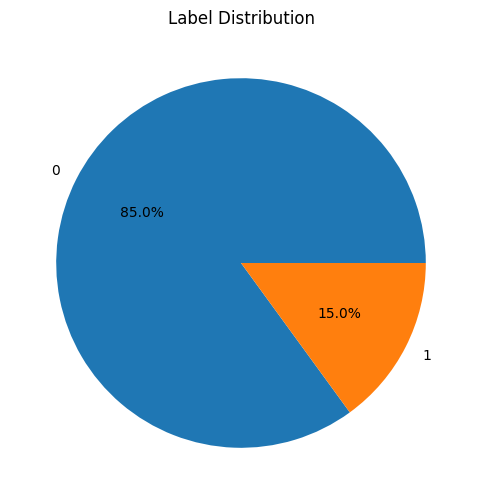

In [157]:
# Pie chart
label_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6), title='Label Distribution')
plt.ylabel('')  # Remove y-label
plt.show()

The data contains a large class imbalance, with only 15% of the data having the True label (student has dropped out). This means that we will have to adjust the setup of the XGBoost and Neural Network models to counteract this imbalance.

### XGBoost

An XGBoost model is a powerful machine learning algorithm based on a gradient boosting algorithm that builds an ensemble of decision trees. — specifically designed to be highly efficient, scalable, and accurate for supervised learning tasks like classification and regression.

Counteracting the class imbalance in the data is important as it will enable the model to learn the meaningful patterns in the data in order to make predictions. Without this, a model could just ignore the minority class in our case and have an accuracy of 85%. We will counteract this by: 

* Using `scale_pos_weight` to give extra importance to the minority class
* Setting `stratify=y` in our `train_test_split` to ensure that the class balance is the same in the train and test sets
* Setting `eval_metric='auc'` because it focuses on ranking predictions rather than simply counting correct ones

The hyperparameters of the model will be tuned using a grid search, where different combinations of hyperparameters will be trialled in order to determine the combination that results in the best model performance.

In [158]:
# Calculate positive weight to give extra importance to minority positive class
scale_pos_weight = label_counts[0] / label_counts[1]
print(scale_pos_weight)

5.675279701651571


In [159]:
def xgboost_model(features, labels):
    """
    Trains and fits an XGBoost model and tunes hyperparameters using Grid Search

    Parameters:
    features (pd.DataFrame): DataFrame containing the features to train the model on
    labels (pd.Series): The true labels for the data

    Returns:
    acc (float): Accuracy score of the tuned model on the test set
    prec (float): Precision score of the tuned model on the test set
    rec (float): Recall score of the tuned model on the test set
    f1 (float): F1 score of the tuned model on the test set
    auc (float): AUC score of the tuned model on the test set

    """    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=y, random_state=seed)
    
    xgb_model = xgb.XGBClassifier(random_state=seed)

    # Define hyperparameter grid
    params = {
        "objective": ["binary:logistic"],
        "scale_pos_weight": [scale_pos_weight],
        "eval_metric": ["auc"],
        "learning_rate": [0.0001, 0.001],
        "max_depth": [15, 20],
        "n_estimators": [100, 150],
    }

    # Set up GridSearchCV
    grid = GridSearchCV(xgb_model, param_grid=params, cv=5)

    # Fit the model
    grid_result = grid.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = grid_result.predict(X_test)
    
    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", grid.best_params_)
    print("Best score: ", grid.best_score_,"\n")
    
    # Print other evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print("Tuned XGBoost Model Accuracy: ", acc)
    print("Tuned XGBoost Model Precision: ", prec)
    print("Tuned XGBoost Model Recall: ", rec)
    print("Tuned XGBoost Model F1 Score: ", f1)
    print("Tuned XGBoost Model AUC: ", auc)
    print("\n",classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
    cfmd.plot()
    plt.show()

    # SHAP for model explainability
    shap.initjs()
    shap_ex = shap.TreeExplainer(grid_result.best_estimator_)
    vals = shap_ex(X_test)
    
    # Beeswarm plot
    shap.plots.beeswarm(vals)

    return acc, prec, rec, f1, auc

Best set of hyperparameters:  {'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 15, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 5.675279701651571}
Best score:  0.863570432860229 

Tuned XGBoost Model Accuracy:  0.8589385474860335
Tuned XGBoost Model Precision:  0.5203327171903882
Tuned XGBoost Model Recall:  0.7496671105193076
Tuned XGBoost Model F1 Score:  0.6142935079105292
Tuned XGBoost Model AUC:  0.8139323583575182

               precision    recall  f1-score   support

           0       0.95      0.88      0.91      4261
           1       0.52      0.75      0.61       751

    accuracy                           0.86      5012
   macro avg       0.74      0.81      0.76      5012
weighted avg       0.89      0.86      0.87      5012



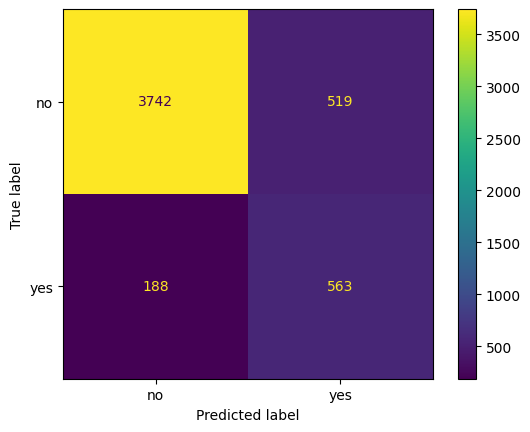

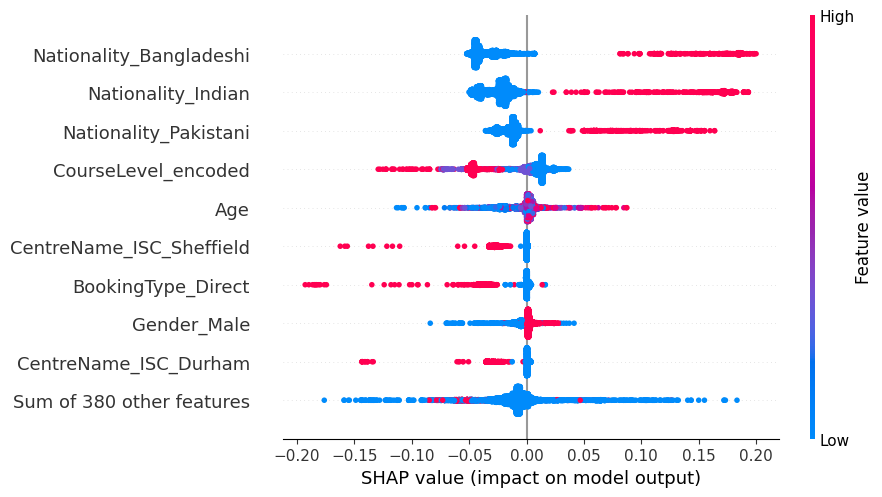

In [160]:
# Fit XGBoost model on Stage 1 Data
xgb_acc_1, xgb_prec_1, xgb_rec_1, xgb_f1_1, xgb_auc_1 = xgboost_model(X, y)

The XGBoost model on Stage 1 data performs reasonably with respect to Accuracy and AUC, but other metrics ,particularly the precision, are poor. SHAP has been used to visualise the importance of the features of the data set in terms of discriminating whether a student will or won't drop out. The top three most important features are whether the student is from Bangladesh, India or Pakistan. This could infer that students from these South Asian countries may require additional support in the programme.

### Neural Network

A neural network is a machine learning model inspired by the structure and function of the human brain, designed to recognize patterns, learn from data, and make predictions or decisions. This makes it very powerful for regression and classification tasks.

Like the XGBoost model, the setup will evaluate based on AUC and undergo hyperparameter tuning with a grid search method.

In [161]:
def create_model(optimizer='adam', activation='relu', dropout_rate=0.3):
    """
    Creates a Neural Network model for use in hyperparameter tuning

    Returns:
    model: Neural Network model for binary classification task
    
    """    
    model = Sequential([keras.Input(shape=INPUT_DIM)])
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # binary classification
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
    return model

In [162]:
def neural_network_model(features, labels):
    """
    Trains and fits a Neural Network model and tunes hyperparameters using Grid Search

    Parameters:
    features (pd.DataFrame): DataFrame containing the features to train the model on
    labels (pd.Series): The true labels for the data

    Returns:
    acc (float): Accuracy score of the tuned model on the test set
    prec (float): Precision score of the tuned model on the test set
    rec (float): Recall score of the tuned model on the test set
    f1 (float): F1 score of the tuned model on the test set
    auc (float): AUC score of the tuned model on the test set

    """      
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=y, random_state=seed)

    global INPUT_DIM
    INPUT_DIM = (X_train.shape[1],)
    
    # Standardise the data.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = KerasClassifier(model=create_model, verbose=0)
    
    param_grid = {
        'batch_size': [16, 32],
        'epochs': [20],
        'optimizer': ['adam', 'sgd'],
    }
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)

    # Best params
    best_params = grid_result.best_params_
    print("Best Params:", best_params)
    
    # Train the model using best parameters
    final_model = create_model(optimizer=best_params['optimizer'])
    history = final_model.fit(X_train, y_train, validation_split=0.2, 
                              epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    
    # Evaluate on test data
    y_pred = final_model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Print other evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print("Neural Network Model Accuracy: ", acc)
    print("Network Model Precision: ", prec)
    print("Neural Network Model Recall: ", rec)
    print("Neural Network Model AUC: ", auc)
    print("\n",classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='--')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot AUC curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['AUC'], label='Training AUC', color='red')
    plt.plot(history.history['val_AUC'], label='Validation AUC', color='red', linestyle='--')
    plt.title('AUC Curves')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

    return acc, prec, rec, f1, auc

2025-07-10 13:36:14.653500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:36:14.674855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:36:14.686979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:36:14.708624: I tensorflow/core/platform/cpu_featu

Best Params: {'batch_size': 16, 'epochs': 20, 'optimizer': 'adam'}
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Model Accuracy:  0.8922585794094174
Network Model Precision:  0.6767169179229481
Neural Network Model Recall:  0.5379494007989347
Neural Network Model AUC:  0.7463274344994438

               precision    recall  f1-score   support

           0       0.92      0.95      0.94      4261
           1       0.68      0.54      0.60       751

    accuracy                           0.89      5012
   macro avg       0.80      0.75      0.77      5012
weighted avg       0.88      0.89      0.89      5012



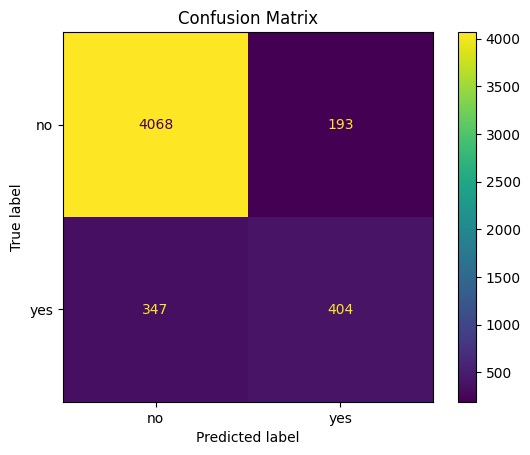

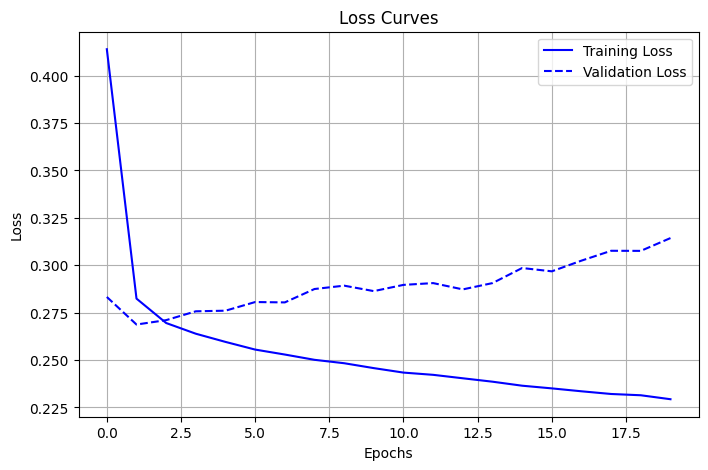

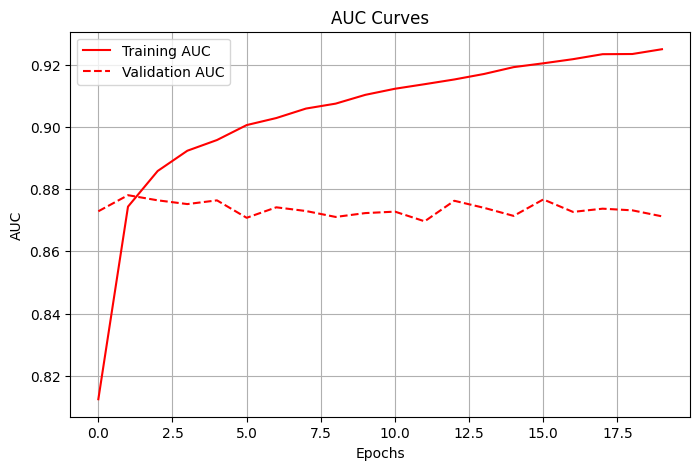

In [164]:
nn_acc_1, nn_prec_1, nn_rec_1, nn_f1_1, nn_auc_1 = neural_network_model(X, y)

The Neural Network has similar performance to the XGBoost model in terms of the metric scores. The loss curve and AUC curve indicate some overfitting in the model as the training performance outstrips the validation performance, which actually gets worse over time. This could be counteracted with early stopping or regularisation techniques.

### Stage 1 Summary

In [165]:
# Visualise evaluation metrics in a table
results = pd.DataFrame({
    "Model": ["XGBoost", "Neural Network"],
    "Accuracy": [xgb_acc_1, nn_acc_1],
    "Precision": [xgb_prec_1, nn_prec_1],
    "Recall": [xgb_rec_1, nn_rec_1],
    "F1 Score": [xgb_f1_1, nn_f1_1],
    "AUC": [xgb_auc_1, nn_auc_1],
})

results.style.highlight_max(subset=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"], color='green')

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBoost,0.858939,0.520333,0.749667,0.614294,0.813932
1,Neural Network,0.892259,0.676717,0.537949,0.599407,0.746327


Overall, the models present reasonable performance with respect to Accuracy, however this is expected due to the class imbalance in the data. The XGBoost model performs better with respect to Recall, F1 Score and AUC, suggesting that this model could be a superior predictor when using Stage 1 data.

As we have seen from the SHAP visualisation, students of South Asian origin appear to be more likely to drop out. This could be an indicator that these students are not receiving enough support, which is something that could be targetted by the business to improve.

---

## Stage 2 Data

Contains all the fields provided in Stage 1 plus two additional fields:

* `AuthorisedAbsenceCount`: Count of lessons where student’s absence was explained and authorised e.g. medical reasons, extenuating circumstances, etc. (across all modules)
* `UnauthorisedAbsenceCount`: Count of lessons where no explanation was given for student absence, or explanation was deemed unsatisfactory (across all modules)

### Initial Data Exploration & Feature Engineering

As with the Stage 1 data, the new data set will undergo the same process of pre-processing and feature engineering.

In [166]:
# Import and visualise data
df2 = pd.read_csv("../data/Stage2_data.csv")

print(df2.shape)
df2.head()

(25059, 18)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN


In [167]:
# Display the data types of the columns and check for missing values
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Progre

In [168]:
# Identify the columns with a large number of unique values
df2.nunique()

CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
DateofBirth                  4705
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
dtype: int64

In [169]:
# Check for any null or missing values
pd.isnull(df2).sum()

CentreName                      0
LearnerCode                     0
BookingType                     0
LeadSource                      0
DiscountType                17464
DateofBirth                     0
Gender                          0
Nationality                     0
HomeState                   16134
HomeCity                     3448
CourseLevel                     0
CourseName                      0
IsFirstIntake                   0
CompletedCourse                 0
ProgressionDegree             875
ProgressionUniversity           0
AuthorisedAbsenceCount        208
UnauthorisedAbsenceCount      208
dtype: int64

In [170]:
# Perform data pre-processing
df2 = pre_processing(df2)

Dropped high-cardinality categorical columns:
  - 'DateofBirth' with 4705 unique values
  - 'HomeState' with 2448 unique values
  - 'HomeCity' with 5881 unique values
  - 'ProgressionDegree' with 2616 unique values
Dropped column 'DiscountType' with 69.7% missing values
Dropped 208 rows due to missing values in 'AuthorisedAbsenceCount'


In [171]:
# Encode categorial features
df2 = categorical_encoding(df2)

In [172]:
# Split data into the predictor and target features
X = df2.drop("Dropout", axis=1)
y = df2["Dropout"]

### XGBoost

Best set of hyperparameters:  {'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 15, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 5.675279701651571}
Best score:  0.8766599597585513 

Tuned XGBoost Model Accuracy:  0.8702474351237176
Tuned XGBoost Model Precision:  0.5418023887079262
Tuned XGBoost Model Recall:  0.6911357340720221
Tuned XGBoost Model F1 Score:  0.6074254412659769
Tuned XGBoost Model AUC:  0.795909123802309

               precision    recall  f1-score   support

           0       0.94      0.90      0.92      4249
           1       0.54      0.69      0.61       722

    accuracy                           0.87      4971
   macro avg       0.74      0.80      0.76      4971
weighted avg       0.89      0.87      0.88      4971



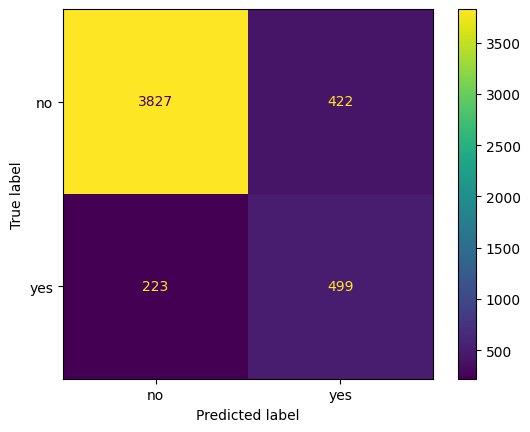

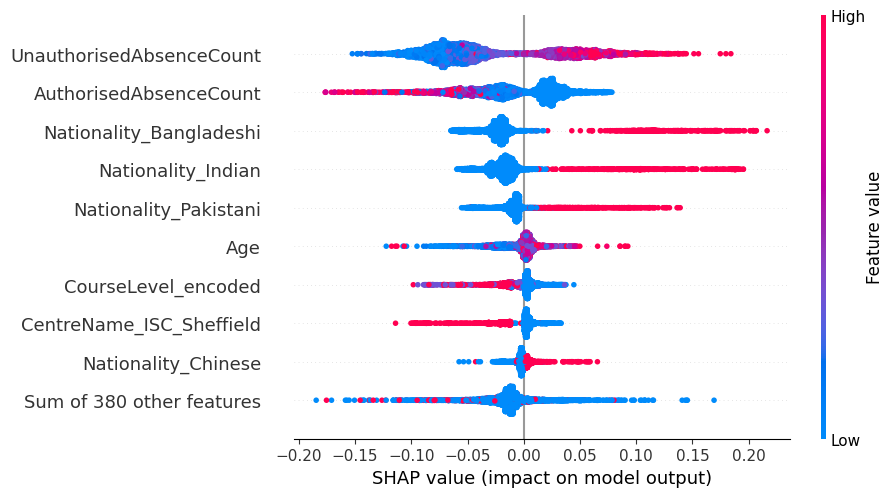

In [173]:
# Fit XGBoost model on Stage 2 Data
xgb_acc_2, xgb_prec_2, xgb_rec_2, xgb_f1_2, xgb_auc_2 = xgboost_model(X, y)

The Stage 2 XGBoost model exhibits similar performance as the model from Stage 1 with regards to the evaluation metrics. The big difference is that in the SHAP visualisation, the most important features are now the two new features `AuthorisedAbsenceCount` and `UnauthorisedAbsenceCount`.

This underlines the importance of ongoing monitoring of the data throughout the whole course, and suggests particularly that there should be some intervention when students are racking up a large number of unauthorised absences. Counterintuitively, the data appears to show that students with a high authorised absence count are less likely to drop out. This could be that students who get their absences authorised are more organised or more likely to take their education seriously.

### Neural Network

2025-07-10 13:48:51.355956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:48:51.372588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:48:51.388590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 13:48:51.397861: I tensorflow/core/platform/cpu_featu

Best Params: {'batch_size': 32, 'epochs': 20, 'optimizer': 'sgd'}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Model Accuracy:  0.8980084490042245
Network Model Precision:  0.670906200317965
Neural Network Model Recall:  0.5844875346260388
Neural Network Model AUC:  0.7678850946841655

               precision    recall  f1-score   support

           0       0.93      0.95      0.94      4249
           1       0.67      0.58      0.62       722

    accuracy                           0.90      4971
   macro avg       0.80      0.77      0.78      4971
weighted avg       0.89      0.90      0.90      4971



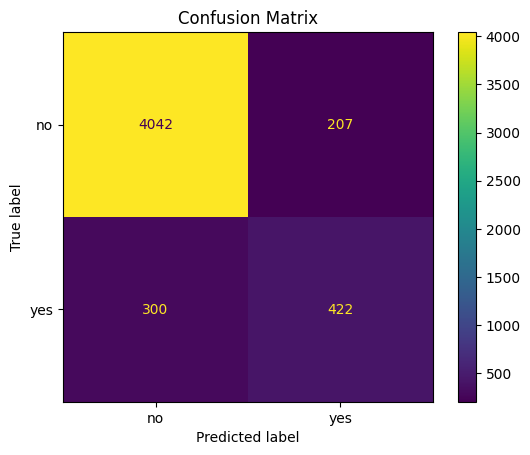

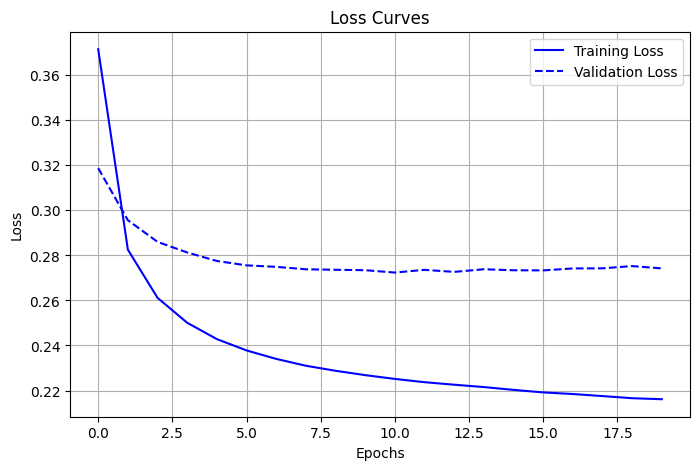

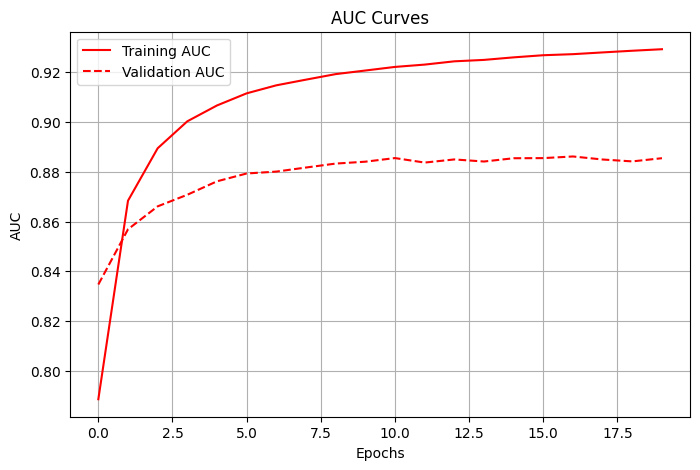

In [174]:
nn_acc_2, nn_prec_2, nn_rec_2, nn_f1_2, nn_auc_2 = neural_network_model(X, y)

The Neural Network for Stage 2 still shows some overfitting as the distance between the training and validation metrics increases over time. However, the validation metrics are improving over the number of epochs for this stage, whereas they were worsening for Stage 1.

### Stage 2 Summary

In [175]:
# Visualise evaluation metrics in a table
results = pd.DataFrame({
    "Model": ["XGBoost", "Neural Network"],
    "Accuracy": [xgb_acc_2, nn_acc_2],
    "Precision": [xgb_prec_2, nn_prec_2],
    "Recall": [xgb_rec_2, nn_rec_2],
    "F1 Score": [xgb_f1_2, nn_f1_2],
    "AUC": [xgb_auc_2, nn_auc_2],
})

results.style.highlight_max(subset=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"], color='green')

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBoost,0.870247,0.541802,0.691136,0.607425,0.795909
1,Neural Network,0.898008,0.670906,0.584488,0.624722,0.767885


Again, the models are performing well on Accuracy, and are reasonably close with respect to the other metrics. The main takeaway from this stage is the importance of ongoing monitoring of student absences, which can be highly predictive of dropout.

---

## Stage 3 Data

Contains all the fields provided in Stage2_data.csv plus 3 additional fields:

* `AssessedModule`: Total number of modules with assessment data  
* `PassedModules`: The total number of modules the learner passed
* `FailedModules`: The total number of modules the learner failed

### Initial Data Exploration & Feature Engineering

The data will undergo the same pre-processing and feature engineering as before.

In [176]:
# Import and visualise data
df3 = pd.read_csv("../data/Stage3_data.csv")

print(df3.shape)
df3.head()

(25059, 21)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [177]:
# Display the data types of the columns and check for missing values
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

In [178]:
# Identify the columns with a large number of unique values
df3.nunique()

CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
DateofBirth                  4705
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
AssessedModules                12
PassedModules                  12
FailedModules                  11
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
dtype: int64

In [179]:
# Check for any null or missing values
pd.isnull(df3).sum()

CentreName                      0
LearnerCode                     0
BookingType                     0
LeadSource                      0
DiscountType                17464
DateofBirth                     0
Gender                          0
Nationality                     0
HomeState                   16134
HomeCity                     3448
CourseLevel                     0
CourseName                      0
IsFirstIntake                   0
CompletedCourse                 0
AssessedModules              2231
PassedModules                2231
FailedModules                2231
ProgressionDegree             875
ProgressionUniversity           0
AuthorisedAbsenceCount        208
UnauthorisedAbsenceCount      208
dtype: int64

In [180]:
# Perform data pre-processing
df3 = pre_processing(df3)

Dropped high-cardinality categorical columns:
  - 'DateofBirth' with 4705 unique values
  - 'HomeState' with 2448 unique values
  - 'HomeCity' with 5881 unique values
  - 'ProgressionDegree' with 2616 unique values
Dropped column 'DiscountType' with 69.7% missing values
Imputed numeric column 'AssessedModules' with mean: 6.090327667776415
Imputed numeric column 'PassedModules' with mean: 5.582880672857894
Imputed numeric column 'FailedModules' with mean: 0.5074469949185211
Dropped 208 rows due to missing values in 'AuthorisedAbsenceCount'


In [181]:
# Encode categorial features
df3 = categorical_encoding(df3)

In [182]:
# Split data into the predictor and target features
X = df3.drop("Dropout", axis=1)
y = df3["Dropout"]

### XGBoost

Best set of hyperparameters:  {'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 20, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 5.675279701651571}
Best score:  0.9874245472837021 

Tuned XGBoost Model Accuracy:  0.9893381613357474
Tuned XGBoost Model Precision:  0.956343792633015
Tuned XGBoost Model Recall:  0.9709141274238227
Tuned XGBoost Model F1 Score:  0.963573883161512
Tuned XGBoost Model AUC:  0.9816914718079339

               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4249
           1       0.96      0.97      0.96       722

    accuracy                           0.99      4971
   macro avg       0.98      0.98      0.98      4971
weighted avg       0.99      0.99      0.99      4971



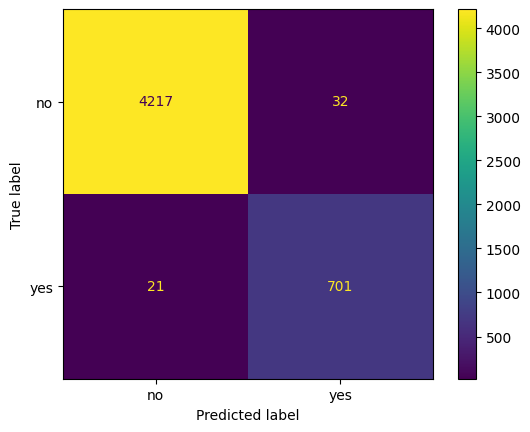

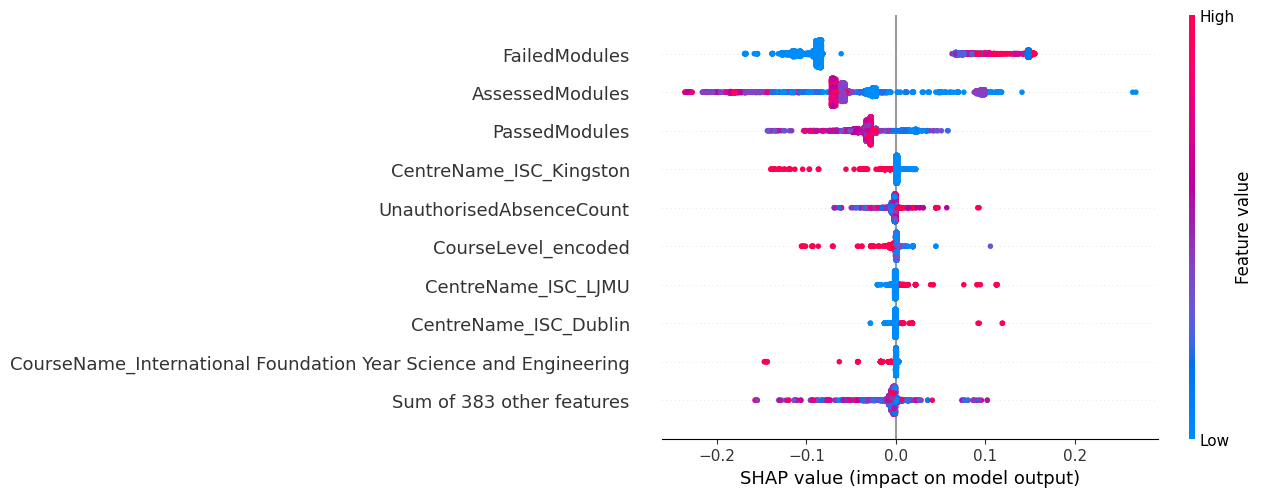

In [183]:
# Fit XGBoost model on Stage 3 Data
xgb_acc_3, xgb_prec_3, xgb_rec_3, xgb_f1_3, xgb_auc_3 = xgboost_model(X, y)

The Stage 3 XGBoost model hugely outperforms the other two models across all of the metrics, which now all show very good performance. This is unsurprising due to the nature of the features added for this stage which are typically available at the end of the course. Students who fail a lot of modules are much more likely to dropout than students who pass.

As this information is typically provided at the end of the year or course it does provide limited scope to intervene so that the student changes course. This does however suggest that predicted grades could also be an excellent indicator of dropout and should be highly monitored throughout the course. This would provide more scope for intervention to provide extra support to those students most at risk.

### Neural Network

Best Params: {'batch_size': 16, 'epochs': 20, 'optimizer': 'sgd'}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Model Accuracy:  0.9326091329712332
Network Model Precision:  0.7927382753403933
Neural Network Model Recall:  0.7257617728531855
Neural Network Model AUC:  0.8467594460876895

               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4249
           1       0.79      0.73      0.76       722

    accuracy                           0.93      4971
   macro avg       0.87      0.85      0.86      4971
weighted avg       0.93      0.93      0.93      4971



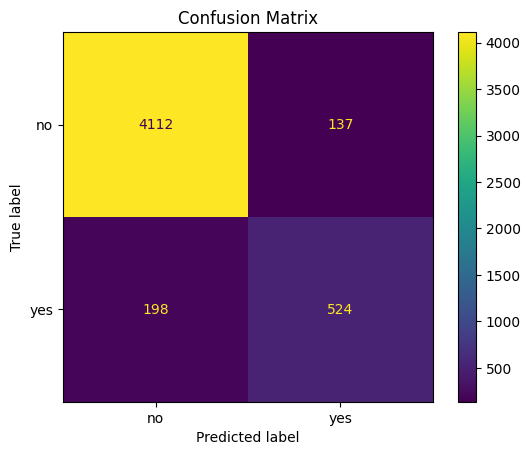

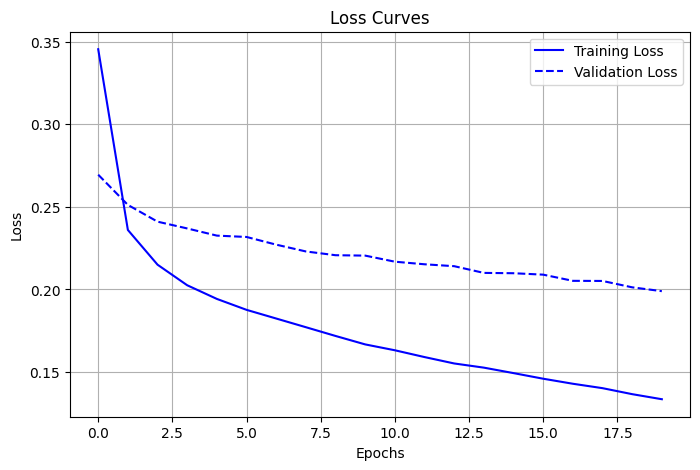

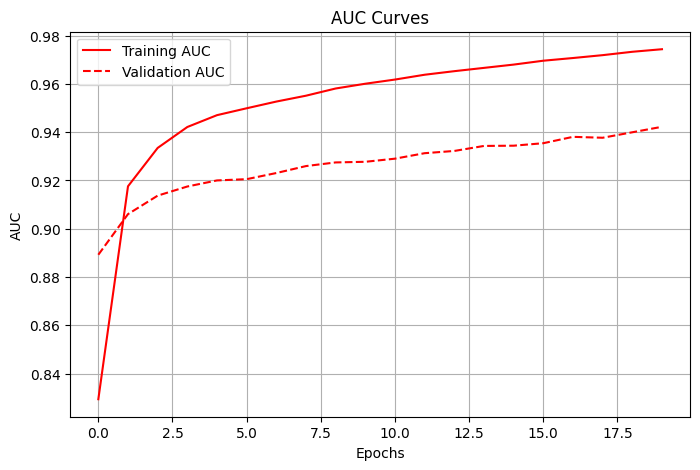

In [184]:
nn_acc_3, nn_prec_3, nn_rec_3, nn_f1_3, nn_auc_3 = neural_network_model(X, y)

The Neural Network also shows greatly improved performance across all metrics, and much lower signs of overfitting than the previous stages.

### Stage 3 Summary

In [185]:
# Visualise evaluation metrics in a table
results = pd.DataFrame({
    "Model": ["XGBoost", "Neural Network"],
    "Accuracy": [xgb_acc_3, nn_acc_3],
    "Precision": [xgb_prec_3, nn_prec_3],
    "Recall": [xgb_rec_3, nn_rec_3],
    "F1 Score": [xgb_f1_3, nn_f1_3],
    "AUC": [xgb_auc_3, nn_auc_3],
})

results.style.highlight_max(subset=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"], color='green')

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBoost,0.989338,0.956344,0.970914,0.963574,0.981691
1,Neural Network,0.932609,0.792738,0.725762,0.757773,0.846759


The XGBoost model in particular displays excellent performance across all metrics, highlighting that it would be an excellent predictor of dropout. However, as explained above the nature of the data provided in Stage 3 offers limited opportunity for intervention as it is provided at the end of the year or course. It does however highlight the importance of monitoring performance throughout the course to come up with predictive grades which could offer the same predictive power with respect to dropout.

---

## Conclusion

All of the models perform well with respect to Accuracy which is likely just due to the class imbalance in the data. The XGBoost models generally perform poorly for Precision and F1 Score in Stage 1 & 2 and slightly better for Recall and AUC.

The Neural Network models generally perform worse than the XGBoost model and show signs of overfitting, which could be counteracted with regularisation or early stopping.

The Stage 3 set provides the best data for predicting dropout, with the XGBoost being the best predictive model by far,  but due to it being provided late in the year / course offers less opportunity for intervention.

In [186]:
# Visualise evaluation metrics in a table
results = pd.DataFrame({
    "Model": ["XGBoost - Stage 1", "Neural Network - Stage 1", "XGBoost - Stage 2", "Neural Network - Stage 2", "XGBoost - Stage 3", "Neural Network - Stage 3"],
    "Accuracy": [xgb_acc_1, nn_acc_1, xgb_acc_2, nn_acc_2, xgb_acc_3, nn_acc_3],
    "Precision": [xgb_prec_1, nn_prec_1, xgb_prec_2, nn_prec_1, xgb_prec_3, nn_prec_3],
    "Recall": [xgb_rec_1, nn_rec_1, xgb_rec_2, nn_rec_2, xgb_rec_3, nn_rec_3],
    "F1 Score": [xgb_f1_1, nn_f1_1, xgb_f1_2, nn_f1_2, xgb_f1_3, nn_f1_3],
    "AUC": [xgb_auc_1, nn_auc_1, xgb_auc_2, nn_auc_2, xgb_auc_3, nn_auc_3],
})

results.style.highlight_max(subset=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"], color='green')

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBoost - Stage 1,0.858939,0.520333,0.749667,0.614294,0.813932
1,Neural Network - Stage 1,0.892259,0.676717,0.537949,0.599407,0.746327
2,XGBoost - Stage 2,0.870247,0.541802,0.691136,0.607425,0.795909
3,Neural Network - Stage 2,0.898008,0.676717,0.584488,0.624722,0.767885
4,XGBoost - Stage 3,0.989338,0.956344,0.970914,0.963574,0.981691
5,Neural Network - Stage 3,0.932609,0.792738,0.725762,0.757773,0.846759


For ongoing monitoring, the data suggests that students from a South Asian background perhaps require more support than other students. The company should also prioritise the monitoring of student absences and predictive grades which both offer high predictive power when it comes to identifying students at risk.